![](https://github.com/gemenerik/RTSR4k/blob/master/baboon_logo.png?raw=true)
#RTSR4k Reproducability Project
**Delft University of Technology**

Deep Learning (CS4240)

Rik Bouwmeester,
Lotte Mulder,
Jort Groen,
Jim Smit
***

**Goal**

To reproduce the results of the paper 'Real-Time Single Image and Video Super-Resolution Using an Efﬁcient Sub-Pixel Convolutional Neural Network' by Shi et al. (2016)
***

**Results to reproduce**

**Table 1**: Results, quantified in mean PSNR (dB), on diffferent test sets using the novel network proposed by the authors: efﬁcient sub-pixel convolutional neural network (ESPCN).
***

Train dataset: 

> T91

Test datasets:
1. Set5
2. Set14
3. BSD300
4. BSD500
5. SuperTexture
***

### Introduction

Currently, super resolution (SR), the recovery of high resolution (HR) images from low resolution (LR) images, is of big interest in the area of digital image processing. To super-resolve a LR image into HR space, it is necessary to increase the resolution of the LR image to match that of the HR image at some point. The state-of-the-art methods for super resolving images scale a LR image to a HR image before or at the first layer of the network [2, 3, 4] or increase the resolution gradually in the middle of the network [5]. However, this increases the computational complexity. Furthermore, the bicubic interpolation method, which is mostly used for upscaling in this type of task, does not give additional information.

The authors of this paper propose a new method, which is a convolutional neural network (CNN) in which the increase in resolution (from LR to HR) is only performed at the end of the network. This is done by a sub-pixel convolutional layer in which the filters are learned. The authors show that this new method achieves state-of-the-art results and that it is one order of magnitude faster. 

In this blogpost, we explain how we reproduced the results in Table 1 of the paper 'Real-Time Single Image and Video Super-Resolution Using an Efﬁcient Sub-Pixel Convolutional Neural Network' by Shi et al. (2016). The reproduction was done from scratch in Google Colab with the use of PyTorch.

The code used in this project is inspired by:
https://github.com/leftthomas/ESPCN

***






### Hyperparameters

Section 3.2.: Implementation details

'To synthesize the low-resolution samples,we blur using a **Gaussian ﬁlter** and sub-sample it by the **upscaling factor**.'



#### Code

In [1]:
#@title Clear data & clone the GitHub repository {display-mode: "form"}
import os

%cd
os.chdir("/content/")
!sudo rm -r RTSR4k
!git clone https://github.com/gemenerik/RTSR4k

os.chdir('RTSR4k/data')
# os.mkdir('val')
os.chdir('..')

/root
rm: cannot remove 'RTSR4k': No such file or directory
Cloning into 'RTSR4k'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (660/660), done.
remote: Compressing objects: 100% (628/628), done.
remote: Total 772 (delta 60), reused 603 (delta 21), pack-reused 112
Receiving objects: 100% (772/772), 55.86 MiB | 29.34 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [2]:
import argparse
import numpy as np
import os
import pylab as pl
import torch.optim
import cv2

from cv2 import imread, PSNR
from IPython import display
from PIL import Image, ImageFilter
from torch import sigmoid, tanh, nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import Compose, CenterCrop, Scale, ToTensor
from tqdm import tqdm

In [3]:
# Tuneable params
UPSCALE_FACTOR = 3 #@param {type:"slider", min:1, max:5, step:1}
GAUSSIAN_BLUR_RADIUS = 0.25 #@param {type:"slider", min:0, max:2, step:0.01}
SUBSAMPLING_STRIDE_SIZE = 14
SUBSAMPLING_SAMPLE_SIZE = 17

# Set learning parameters
no_learning_threshold = 1e-8  # threshold for stopping training when no improvement has been made for 'repeats' epochs
                              # Referred to in the paper as 'mu'
repeats = 100 # the number of consecutive epochs without (enough) improvement necessary to stop training 

# Define test sets
test_sets = ['Set5', 'Set14', 'BSD300', 'BSD500']

***

### Network

From within the YCbCr colour space of a LR image, the luminance channel (Y) is passed through 3 convolutional layers. Hereafter, a “sub-pixel convolution layer” is applied that merges the different output channels into one high resolution image. The HR image can be seen as an image with a resolution equal to LR where every pixel is composed of multiple “sub-pixels”. The sub-pixels are composed out of r^2 different output channels, obtained from the last convolutional layer. This way, the HR image is enlarged by a factor r.

#### Code

In [4]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = tanh(self.conv1(x))
        x = tanh(self.conv2(x))
        x = sigmoid(self.pixel_shuffle(self.conv3(x)))
        return x

***

### Data processing 

Generate train, test and validation datasets given the set Upscaling factor. 

Before images are passed through the network, they are first converted from RGB to YCbCr. In the YCbCr colourspace, both the low and high resolution images share the Cb and Cr channel (the blue-difference and red-difference chroma components). This way, only the Y (luminance) channel has to be passed through the network. The autors used this trick to decrease the size of the inputs and therewith be able to increase the speed of the network.

All images are split into 17r by 17r subimages, where r is the upscale factor, using a stride of 14. This results in the HR data. Next, downscaling with a factor r results in the LR data.

#### Code

In [5]:
import math
from torchvision.transforms import Resize

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.JPG', '.JPEG', '.PNG', '.bmp'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def blur(img):
    return img.filter(ImageFilter.GaussianBlur(GAUSSIAN_BLUR_RADIUS))


def input_transform(size):
    return Compose([Resize(size), blur])


def target_transform(crop_size):
    return Compose([CenterCrop(crop_size)])


# credits to github.com/mrlomar for sharing this patch-generation code with us
def sub_image_generation(img, upscale_factor):
    sub_image_dim = SUBSAMPLING_SAMPLE_SIZE * upscale_factor
    sub_image_stride = SUBSAMPLING_STRIDE_SIZE * upscale_factor
    sub_image_list = []
    for v in range(math.floor((img.shape[0] - (sub_image_dim - sub_image_stride)) / sub_image_stride)):
        for u in range(math.floor((img.shape[1] - (sub_image_dim - sub_image_stride)) / sub_image_stride)):
            sub_image = img[(v * sub_image_stride):(v * sub_image_stride) + sub_image_dim,
                 (u * sub_image_stride):(u * sub_image_stride) + sub_image_dim]
            sub_image_list.append(sub_image)

    return sub_image_list


class DatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_dir = dataset_dir + '/scaling_factor_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/scaling_factor_' + str(upscale_factor) + '/target'
        self.image_filenames = [os.path.join(self.image_dir, x) for x in os.listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [os.path.join(self.target_dir, x) for x in os.listdir(self.target_dir) if is_image_file(x)]
        print(os.listdir(self.target_dir))
        print(self.target_filenames)
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image, _, _ = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        target, _, _ = Image.open(self.target_filenames[index]).convert('YCbCr').split()
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)


def generate_dataset(data_type, upscale_factor, data_target):
    images_name = [x for x in os.listdir('data/' + data_type) if is_image_file(x)]

    root = 'data/' + data_target
    if not os.path.exists(root):
        os.makedirs(root)
    path = root + '/scaling_factor_' + str(upscale_factor)
    if not os.path.exists(path):
        os.makedirs(path)
    image_path = path + '/data'
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    target_path = path + '/target'
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    temp_path = 'data/' + 'temp'
    if not os.path.exists(temp_path):
        os.makedirs(temp_path)

    patch_dimension_list = []
    for image_name in tqdm(images_name, desc='generate ' + data_type + ' dataset with upscale factor = '
            + str(upscale_factor) + ' from dataset'):
        image = Image.open('data/' + data_type + '/' + image_name)
        extension = os.path.splitext(image_name)[1]
        if not extension == '.jpg': # convert all to jpg
            image_name = image_name.replace(extension, '.jpg')
            image.save('data/' + 'temp' + '/' + image_name)
            image = Image.open('data/' + 'temp' + '/' + image_name)
            image_np = imread('data/' + 'temp' + '/' + image_name)
        else:
            image_np = imread('data/' + data_type + '/' + image_name)
            # image.save('')

        # image.save('data/' + data_type + '/' + image_name)


        subsamples = sub_image_generation(image_np, UPSCALE_FACTOR)
        # target = blur(target)
        for i in range(0, len(subsamples)):
            extension = os.path.splitext(image_name)[1]
            img = Image.fromarray(subsamples[i], 'RGB')
            image_name_new = image_name.replace(extension, '_' + str(i) + extension)
            # print(extension, image_name_new)
            # img.save(image_path + '/' + image_name_new)
            img.save(target_path + '/' + image_name_new)
            size = img.size
            size = tuple(s // UPSCALE_FACTOR for s in size)
            lr_transform = input_transform(size)
            image_lr = lr_transform(img)
            image_lr.save(image_path + '/' + image_name_new)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Generate Super Resolution Dataset')
    parser.add_argument('--upscale_factor', default=100, type=int, help='super resolution upscale factor')

    generate_dataset(data_type='original_data/train', upscale_factor=UPSCALE_FACTOR, data_target='train')
    for i in test_sets:
      generate_dataset(data_type='original_data/test/' + i, upscale_factor=UPSCALE_FACTOR, data_target='test/'+i)
      # generate_dataset(data_type='val', upscale_factor=UPSCALE_FACTOR, data_target='val')
      # val set is made in train

generate original_data/train dataset with upscale factor = 3 from dataset: 100%|██████████| 91/91 [00:05<00:00, 17.67it/s]
generate original_data/test/Set5 dataset with upscale factor = 3 from dataset: 100%|██████████| 5/5 [00:00<00:00,  9.59it/s]
generate original_data/test/Set14 dataset with upscale factor = 3 from dataset: 100%|██████████| 14/14 [00:03<00:00,  4.35it/s]
generate original_data/test/BSD300 dataset with upscale factor = 3 from dataset: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]
generate original_data/test/BSD500 dataset with upscale factor = 3 from dataset: 100%|██████████| 200/200 [00:13<00:00, 14.77it/s]


***

### Train

1. Create the Neural Network (Net)
2. Try to run on cuda device (GPU) if available
3. Load the saved train and test sets
4. Choose training cirterion, optimizer and number of epochs
5. Train the Network and visualize the loss over the epochs

#### Code

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)
Start training Net with sigma:  0.25
Running on cuda
['t54_0.jpg', 'tt12_14.jpg', 't38_13.jpg', 't1_3.jpg', 't56_6.jpg', 't38_25.jpg', 'tt14_13.jpg', 'tt22_19.jpg', 'tt12_36.jpg', 't52_26.jpg', 'tt1_23.jpg', 't30_0.jpg', 'tt3_17.jpg', 't40_5.jpg', 't58_16.jpg', 't53_0.jpg', 'tt20_1.jpg', 'tt1_32.jpg', 'tt24_36.jpg', 't31_10.jpg', 't51_28.jpg', 'tt14_8.jpg', 'tt15_0.jpg', 't56_10.jpg', 'tt4_50.jpg', 'tt2_16.jpg', 't63_14.jpg', 'tt26_19.jpg', 'tt25_37.jpg', 't15_10.jpg', 't46_5.jpg', 'tt8_50.jpg', 'tt9_29.jpg', 'tt3_64.jpg', 'tt1_11.jpg', 't58_11.jpg', 'tt5_59.jpg', 't66_30.jpg', 'tt2_38.jpg', 'tt26_51.jpg', 'tt10_15.jpg', 'tt25_51.jpg', 't45_2.jpg', 'tt5_34.jpg', 't46_26.jpg', 't23_0.jpg', 't64_7.jpg', 'tt

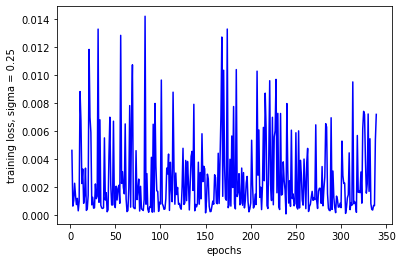

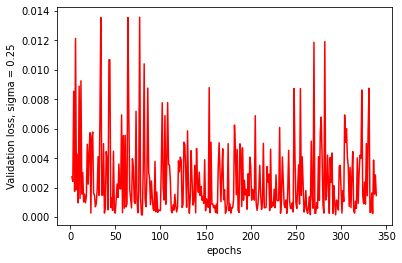

In [7]:
if __name__ == "__main__":
    # Define path to save the model to
    PATH = './Trained_' + str(GAUSSIAN_BLUR_RADIUS) + '.pth'

    # gauss_range = np.linspace(0.001, 1, num=10)

    # Run the functions to generate the datasets: Train, test and val
    # generate_dataset(data_type='original_data/train', upscale_factor=UPSCALE_FACTOR, data_target='train')

    # 1. Create the Neural Network (Net)
    net = Net(upscale_factor=UPSCALE_FACTOR)
    print(net)
    print('Start training Net with sigma: ', GAUSSIAN_BLUR_RADIUS)
    
    # 2. Try to run on cuda device (GPU) if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Running on', device)
    if device == 'cuda':
        net.cuda()
    transform = Compose([
        # you can add other transformations in this list
        ToTensor()
    ])

    # 3. Load the saved train set

    trainset = DatasetFromFolder('data/train', upscale_factor=UPSCALE_FACTOR, input_transform=ToTensor(),
                                 target_transform=ToTensor())

    # Assign 0.05 share of the training data to the validation set
    validation_split = 0.05
    shuffle_dataset = True
    random_seed = 42

    # Creating data indices for training and validation splits:
    dataset_size = len(trainset)
    indices = list(range(dataset_size))

    val_len = int(np.floor(validation_split * dataset_size))
    validation_idx = np.random.choice(indices, size=val_len, replace=False)
    train_idx = list(set(indices) - set(validation_idx))

    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[val_len:], indices[:val_len]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, num_workers=2,
                                              sampler=train_sampler)

    valloader = torch.utils.data.DataLoader(trainset, batch_size=2,
                                            num_workers=2,
                                            sampler=valid_sampler)

    data_loaders = {"train": trainloader, "val": valloader}
    data_lengths = {"train": len(train_idx), "val": val_len}

    # print('training images: ', data_lengths['train'], 'validation images: ', data_lengths['val'])
    # 4. Choose training cirterion, optimizer and number of epochs

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    number_of_epochs = 3

    " train net "
    epochs = []
    train_losses = []
    val_losses = []

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # learning rate decay

    # 5. Train the Network untill the improvement in loss is marginal for at least 50 epochs


    best_train_loss = float("inf")  # start with dummy value for best train loss
    epoch = 0
    # for epoch in range(number_of_epochs):  # loop over the dataset multiple times
        # if epoch % 10 == 1:
        #     print('Epoch {}/{}'.format(epoch, number_of_epochs - 1))
            # print('lr: ' + str(scheduler.get_lr()))

    while True:  # loop over the dataset multiple times

        for phase in ['train', 'val']:
          if phase == 'train':
              net.train(True)  # Set model to training mode
          else:
              net.train(False)  # Set model to evaluate mode

          running_loss = 0.0      # reset both losses

          for i, data in enumerate(data_loaders[phase], 0):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            running_loss = + loss.item() * outputs.shape[0]
          if phase == 'train':
            train_losses.append(running_loss)
            epoch_train_loss = running_loss
          else:
            val_losses.append(running_loss)
            epoch_val_loss = running_loss

        # if epoch % 10 == 1:
        #     print('{} Loss: {:.4f}'.format(phase, running_loss))

        improvement = best_train_loss - epoch_train_loss

        if improvement > 0:  # save best model, 'best' meaning lowest loss on test set
            best_train_loss = epoch_train_loss
            print('overwiting the model')
            torch.save(net.state_dict(), PATH)  # overwrite best model so the best model filename doesn't change
            # update best epcoh and best epoch loss
            best_epoch = epoch
            best_epoch_train_loss = epoch_train_loss

        # stop training if no improvement has been made for 'repeats' epochs
            print("epoch " + str(epoch + 1) + ': \n training loss: ', epoch_train_loss, '\n validation loss: ', epoch_val_loss, '\n improvement = ' + str(improvement))
          
            if improvement < no_learning_threshold:
                ni_counter += 1
                print('Number of epochs with no or marginal loss improvement: ',ni_counter)
            else:
                ni_counter = 0
        else:
          ni_counter += 1
          print('Number of epochs with no or marginal loss improvement: ',ni_counter)

        if ni_counter >= repeats:
            break
        else:
          epoch = epoch + 1

        epochs.append(epoch + 1)

    pl.figure()
    pl.plot(epochs, train_losses[1:], '-b')
    pl.xlabel('epochs')
    pl.ylabel('training loss, sigma = ' + str(GAUSSIAN_BLUR_RADIUS))


    pl.figure()
    pl.plot(epochs, val_losses[1:], 'r')
    pl.xlabel('epochs')
    pl.ylabel('Validation loss, sigma = ' + str(GAUSSIAN_BLUR_RADIUS))


    print('Finished Training')
    print('Best loss at epoch ', best_epoch, 'with loss of ', best_epoch_train_loss)
    " save "
    # torch.save(net.state_dict(), PATH)

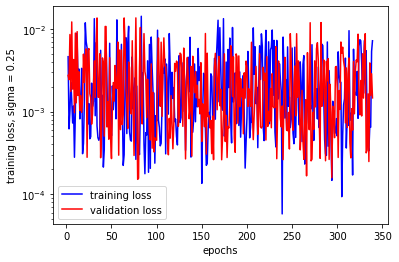

In [8]:
pl.figure()
pl.plot(epochs, train_losses[1:], '-b')
pl.plot(epochs, val_losses[1:], 'r')
pl.xlabel('epochs')
pl.ylabel('training loss, sigma = ' + str(GAUSSIAN_BLUR_RADIUS))
pl.legend(['training loss', 'validation loss'])
pl.yscale('log')

***

### Results

In the paper, the *PSNR* is used as a quality measurement between the original and a compressed image. The higher the *PSNR*, the better the quality of the compressed, or reconstructed image.

Derivation:

$$ MSE = \frac{\sum_{M,N} [Image_1(m,n) - Image_2(m,n)]^{2}}{M*N}$$

$$ PNSR = 10*log{10}( \frac{R^{2}}{MSE})$$

Where R is the maximum fluctuation in the input image data type. For example, if the input image has a double-precision floating-point data type, then R is 1. If it has an 8-bit unsigned integer data type, R is 255, etc The PNSR function of cv2 package is used.

#### Code


 Evaluating scores for:  Set5
['baby_98.jpg', 'bird_13.jpg', 'baby_101.jpg', 'baby_109.jpg', 'bird_2.jpg', 'bird_9.jpg', 'bird_32.jpg', 'bird_5.jpg', 'baby_103.jpg', 'baby_95.jpg', 'baby_46.jpg', 'baby_47.jpg', 'butterfly_18.jpg', 'baby_80.jpg', 'baby_23.jpg', 'bird_30.jpg', 'baby_82.jpg', 'bird_25.jpg', 'woman_30.jpg', 'baby_26.jpg', 'woman_1.jpg', 'bird_14.jpg', 'baby_115.jpg', 'baby_118.jpg', 'bird_11.jpg', 'bird_6.jpg', 'bird_27.jpg', 'butterfly_14.jpg', 'bird_31.jpg', 'baby_89.jpg', 'baby_114.jpg', 'baby_42.jpg', 'baby_43.jpg', 'woman_8.jpg', 'baby_12.jpg', 'bird_18.jpg', 'head_35.jpg', 'bird_35.jpg', 'baby_96.jpg', 'baby_119.jpg', 'woman_19.jpg', 'baby_111.jpg', 'baby_107.jpg', 'baby_68.jpg', 'baby_94.jpg', 'baby_70.jpg', 'woman_5.jpg', 'head_15.jpg', 'woman_23.jpg', 'head_21.jpg', 'baby_54.jpg', 'baby_21.jpg', 'baby_87.jpg', 'butterfly_6.jpg', 'head_8.jpg', 'bird_19.jpg', 'head_29.jpg', 'head_31.jpg', 'baby_11.jpg', 'bird_22.jpg', 'woman_3.jpg', 'baby_91.jpg', 'baby_116.jpg', '


 High res image before downsacling (target): 



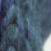


 Upscaled image by Bicubic interpolation: 



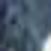


 Upscaled image using ESPCN trained Network (result): 



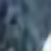


 Test set: Set5
sigma:  0.25 Mean PSNR:  [29.176468478292485]

 Evaluating scores for:  Set14
['bridge_64.jpg', 'monarch_111.jpg', 'lenna_49.jpg', 'ppt3_150.jpg', 'foreman_14.jpg', 'baboon_60.jpg', 'monarch_70.jpg', 'pepper_111.jpg', 'man_35.jpg', 'monarch_72.jpg', 'pepper_112.jpg', 'pepper_2.jpg', 'bridge_30.jpg', 'pepper_37.jpg', 'monarch_29.jpg', 'coastguard_5.jpg', 'bridge_71.jpg', 'baboon_40.jpg', 'monarch_136.jpg', 'monarch_103.jpg', 'lenna_7.jpg', 'zebra_12.jpg', 'monarch_101.jpg', 'monarch_80.jpg', 'pepper_41.jpg', 'monarch_42.jpg', 'monarch_47.jpg', 'zebra_91.jpg', 'coastguard_19.jpg', 'monarch_139.jpg', 'man_48.jpg', 'flowers_73.jpg', 'barbara_8.jpg', 'flowers_5.jpg', 'baboon_75.jpg', 'zebra_10.jpg', 'face_2.jpg', 'monarch_28.jpg', 'comic_21.jpg', 'coastguard_8.jpg', 'bridge_86.jpg', 'coastguard_36.jpg', 'baboon_14.jpg', 'lenna_22.jpg', 'monarch_10.jpg', 'zebra_100.jpg', 'lenna_20.jpg', 'barbara_11.jpg', 'barbara_24.jpg', 'ppt3_36.jpg', 'flowers_68.jpg', 'monarch_184.jpg', '


 High res image before downsacling (target): 



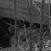


 Upscaled image by Bicubic interpolation: 



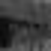


 Upscaled image using ESPCN trained Network (result): 



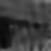


 Test set: Set14
sigma:  0.25 Mean PSNR:  [26.46345682726104]

 Evaluating scores for:  BSD300
['304074_24.jpg', '157055_36.jpg', '175032_9.jpg', '97033_25.jpg', '299086_46.jpg', '108005_3.jpg', '253055_32.jpg', '78004_16.jpg', '103070_1.jpg', '101085_50.jpg', '38082_63.jpg', '210088_67.jpg', '86000_36.jpg', '130026_56.jpg', '148026_31.jpg', '58060_67.jpg', '216081_48.jpg', '69040_63.jpg', '106024_36.jpg', '58060_38.jpg', '167062_49.jpg', '21077_31.jpg', '160068_49.jpg', '108070_68.jpg', '19021_18.jpg', '78004_27.jpg', '87046_7.jpg', '86016_27.jpg', '296007_20.jpg', '189080_62.jpg', '376043_33.jpg', '86016_47.jpg', '160068_17.jpg', '285079_14.jpg', '167083_38.jpg', '106024_50.jpg', '76053_74.jpg', '241048_33.jpg', '43074_58.jpg', '197017_11.jpg', '45096_5.jpg', '38082_10.jpg', '33039_26.jpg', '145086_20.jpg', '85048_48.jpg', '3096_28.jpg', '41033_25.jpg', '126007_8.jpg', '227092_36.jpg', '69040_76.jpg', '145086_41.jpg', '260058_33.jpg', '163085_68.jpg', '101087_31.jpg', '253055_60.jpg


 High res image before downsacling (target): 



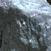


 Upscaled image by Bicubic interpolation: 



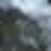


 Upscaled image using ESPCN trained Network (result): 



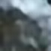


 Test set: BSD300
sigma:  0.25 Mean PSNR:  [26.616426037654392]

 Evaluating scores for:  BSD500
['302022_35.jpg', '302022_34.jpg', '118031_56.jpg', '123057_73.jpg', '146074_64.jpg', '117025_39.jpg', '160006_55.jpg', '128035_19.jpg', '217090_67.jpg', '163096_62.jpg', '100007_18.jpg', '145059_39.jpg', '185092_31.jpg', '232076_42.jpg', '309040_23.jpg', '100039_12.jpg', '102062_39.jpg', '176051_19.jpg', '228076_44.jpg', '109055_66.jpg', '209021_27.jpg', '187099_68.jpg', '226033_57.jpg', '160067_65.jpg', '157032_15.jpg', '326025_59.jpg', '117025_34.jpg', '168084_54.jpg', '107045_29.jpg', '289011_28.jpg', '106047_20.jpg', '388006_16.jpg', '326025_52.jpg', '281017_15.jpg', '120003_8.jpg', '107014_31.jpg', '160006_19.jpg', '108036_58.jpg', '228076_71.jpg', '108004_8.jpg', '103029_37.jpg', '16068_50.jpg', '107014_68.jpg', '147077_51.jpg', '223060_57.jpg', '112056_52.jpg', '16004_76.jpg', '123057_65.jpg', '217013_57.jpg', '226022_4.jpg', '206062_58.jpg', '189006_0.jpg', '118072_9.jpg', '207049


 High res image before downsacling (target): 



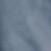


 Upscaled image by Bicubic interpolation: 



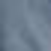


 Upscaled image using ESPCN trained Network (result): 



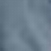


 Test set: BSD500
sigma:  0.25 Mean PSNR:  [26.9497462444323]


In [9]:
test_results = []
for test_set in test_sets:
    print('\n', 'Evaluating scores for: ', test_set)

    # generate_dataset(data_type='original_data/test/' + test_set, upscale_factor=UPSCALE_FACTOR,
    #                  data_target='test_' + test_set)

    " load nets for different sigma values "
    # gauss_range = np.linspace(0.001, 1, num=10)

    means = []
    PATH = './Trained_' + str(GAUSSIAN_BLUR_RADIUS) + '.pth'
    net = Net(UPSCALE_FACTOR)
    net.load_state_dict(torch.load(PATH))

    i = UPSCALE_FACTOR
    path = 'data/test/' + test_set + '/scaling_factor_%s/' % i  # Define test data path with correct scaling factor
    # print(path)
    image_list = os.listdir(path + '/data/')
    print(image_list)
    PSNR_list = []

    count = 0
    for j in image_list:
        count = count + 1
        img = Image.open(path + '/data/' + j).convert('YCbCr')  # Load low Res input image from the test data
        y, cb, cr = img.split()  # Transform image into individual channels of the Ycbcr color space
        image = Variable(ToTensor()(y)).view(1, -1, y.size[1], y.size[0]) # Transform to tensors

        out = net(image)
        out_img_y = out.data[0].numpy()
        out_img_y *= 255.0
        out_img_y = out_img_y.clip(0, 255)
        out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
        out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
        out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
        super_res_image = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
        super_res_image.save('test.jpg')

        # PSNR
        original = imread(path + 'target/' + j)
        contrast = imread('test.jpg', 1)
        PSNR_list.append(PSNR(original, contrast))

        if count == 1:
            # print('RESULTS FOR SIGMA: ', str(GAUSSIAN_BLUR_RADIUS))
            # review image
            low_res_image = Image.open(path + 'data/' + j)
            print('\n The low res image (input in the Network): \n')
            display.display(low_res_image)
            # low_res_image.show()
            high_res_image = Image.open(path + 'target/' + j)  # Load High Res image from the target data
            print('\n High res image before downsacling (target): \n')
            display.display(high_res_image)
            # upscaled image by bicubic interpolation
            bicubic = low_res_image.resize(high_res_image.size)
            print('\n Upscaled image by Bicubic interpolation: \n')
            display.display(bicubic)
            # high_res_image.show()
            print('\n Upscaled image using ESPCN trained Network (result): \n')
            display.display(super_res_image)
            # super_res_image.show()
            # input("Press Enter to continue...")

    # print('Peak Signal-to-Noise ratio between original (high res) and upscaled image by ESPCN:')
    # for i in range(0, len(image_list)):
    #   print(image_list[i], PSNR_list[i])
    # print('\n','Mean PSNR', mean(PSNR_list))
    means.append(np.mean(PSNR_list))
    test_results.append(np.mean(PSNR_list))
    print('\n', 'Test set:', test_set)
    print('sigma: ', GAUSSIAN_BLUR_RADIUS, 'Mean PSNR: ', means)


In [10]:
import pandas as pd

df = pd.DataFrame(index = test_sets, columns = ['Result by Shi et al. (PSNR)', 'Result by us (PSNR)'])
df['Result by Shi et al. (PSNR)'] = [32.55, 29.08, 28.26, 28.34]
df['Result by us (PSNR)'] = test_results

print(df)

        Result by Shi et al. (PSNR)  Result by us (PSNR)
Set5                          32.55            29.176468
Set14                         29.08            26.463457
BSD300                        28.26            26.616426
BSD500                        28.34            26.949746
